## INTRODUCCION

Haremos un analisis exploratorio de cada uno de los DataFrames que componen el poryecto lo que haremos en cada uno sera:

* Buscar valores nulos
* Buscar valores duplicados
* Visualizar los tipos de datos en cada columnay en su caso cambiarlos

## Plan de trabajo

Hemos corregido los errores que se encontraron en los dataframes lo siguiente sera:

- Unir los DataFrame: Se uniran los cuatro DataFrames con todos los 7043 valores lo siguiente sera rellenar los valores que nos queden nulos con la palabra 'No' consideramos que esto es correcto ya que eso quiere decir que el usuario no tiene contratado cierto servicio.


- Podemos ver que existe desbalance en los datos por lo que ademas construiremos un nuevo dataframe sobreajustado para entrenar modelos y tratar de obtener mejores resultados.


- Codificacion de los valores: Se usaran los metodos 'One Hot Encoding' y 'Ordinal Encoder' y se usaran en los modelos Logistic Regression y Random Forest Classifier espectivamente, los datos codificados con 'Ordinal Encoder' se usaran tambien para construir el algoritmo Boruta


- Seleccion de los datos: Usaremos el algoritmo 'Boruta' para evaluar la importancia de cada columna ya que si no son relevantes bajarian la calidad de prediccion del modelo por lo tanto seleccionaremos de esta manera las columnas que usaremos en los entrenamientos de los diferentes modelos.


- Entrenamiento de modelos: Tomaremos modelos como 'Logistic Regression' y  'Random Forest Classification' pero tambien usaremos modelos de potenciacion de gradiente como 'CatBoostClassifier' y 'LightGBM' y seleccionaremos al que nos de el mejor valor AUC ROC.

In [1]:
pip install boruta

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from boruta import BorutaPy
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    recall_score,
    precision_score,
    f1_score,
    roc_auc_score,
    roc_curve
)
from catboost import CatBoostClassifier, Pool, cv
import lightgbm as lgb

## Carga de datos

In [3]:
df_contract = pd.read_csv('/datasets/final_provider/contract.csv')
df_phone = pd.read_csv('/datasets/final_provider/phone.csv')
df_personal = pd.read_csv('/datasets/final_provider/personal.csv')
df_internet = pd.read_csv('/datasets/final_provider/internet.csv')

## df_contract

In [4]:
df_contract

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


In [5]:
df_contract.rename(columns={'customerID':'customer_id', 'BeginDate':'begin_date', 'EndDate':'end_date',
                           'Type':'type', 'PaperlessBilling': 'paperless_billing', 'PaymentMethod':'payment_method',
                           'MonthlyCharges':'monthly_charges', 'TotalCharges':'total_charges'}, inplace=True)
df_contract

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


In [6]:
df_contract.isna().sum()

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
dtype: int64

In [7]:
df_contract.duplicated().sum()

0

In [8]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [9]:
df_contract.describe()

,monthly_charges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [10]:
df_contract['end_date'].value_counts()

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: end_date, dtype: int64

Existe una columna con valores numericos que tiene tipo objeto entonces lo cambiaremos.

In [11]:
#df_contract['total_charges'].astype('float')

Al ejecutar la linea anterior nos dice que existen valores que no son nulos pero son espacios por lo que no contienen nada y no podemos cambiar el tipo de dato, buscaremos esos valores y los cambiaremos con 0

In [12]:
# Buscamos valores
df_contract.query('total_charges == " "')

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


In [13]:
# Cambiamos valores
df_contract.loc[df_contract['total_charges'] == ' ', 'total_charges'] = 0

In [14]:
# Revisamos que los cambios que realizaran correctamente
df_contract.query('total_charges == " "')

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges


In [15]:
# Cambiamos tipo de dato
df_contract['total_charges'] = df_contract['total_charges'].astype('float64')

In [16]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


## df_personal

In [17]:
df_personal

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


In [18]:
df_personal.rename(columns={'customerID':'customer_id', 'SeniorCitizen': 'senior_citizen', 'Partner':'partner', 'Dependents':'dependents'}, inplace=True)
df_personal.head()

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [19]:
df_personal.isna().sum()

customer_id       0
gender            0
senior_citizen    0
partner           0
dependents        0
dtype: int64

In [20]:
df_personal.duplicated().sum()

0

In [21]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [22]:
df_personal.describe()

,senior_citizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [23]:
space = df_personal.drop(columns=['senior_citizen']).applymap(str.isspace)
row_with_space = space.any(axis=1)
df_filtered = df_personal[row_with_space]

df_filtered

,customer_id,gender,senior_citizen,partner,dependents


## df_internet

In [24]:
df_internet = pd.read_csv('/datasets/final_provider/internet.csv')
df_internet

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [25]:
df_internet.rename(columns={'customerID':'customer_id', 'InternetService':'internet_service', 'OnlineSecurity':'online_security',
                           'OnlineBackup':'oline_backup', 'DeviceProtection':'device_protection', 'TechSupport':'tech_support',
                           'StreamingTV':'streaming_tv', 'StreamingMovies':'streaming_movies'}, inplace=True)
df_internet.head()

,customer_id,internet_service,online_security,oline_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [26]:
df_internet.isna().sum()

customer_id          0
internet_service     0
online_security      0
oline_backup         0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
dtype: int64

In [27]:
df_internet.duplicated().sum()

0

In [28]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   oline_backup       5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [29]:
space = df_internet.applymap(str.isspace)
row_with_space = space.any(axis=1)
df_filtered = df_internet[row_with_space]

df_filtered

,customer_id,internet_service,online_security,oline_backup,device_protection,tech_support,streaming_tv,streaming_movies


## df_phone

In [30]:
df_phone

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


In [31]:
df_phone.rename(columns={'customerID':'customer_id', 'MultipleLines':'multiple_lines'}, inplace=True)
df_phone.head()

,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [32]:
df_phone.isna().sum()

customer_id       0
multiple_lines    0
dtype: int64

In [33]:
df_phone.duplicated().sum()

0

In [34]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [35]:
space = df_phone.applymap(str.isspace)
row_with_space = space.any(axis=1)
df_filtered = df_phone[row_with_space]

df_filtered

,customer_id,multiple_lines


In [36]:
df_phone.describe()

,customer_id,multiple_lines
count,6361,6361
unique,6361,2
top,1895-QTKDO,No
freq,1,3390


## Construcción del target y union de DataFrames

In [37]:
df_contract["target"] = (~(df_contract["end_date"] == "No")).astype("int8")

In [38]:
model_dataset = (
    df_contract
    .merge(df_personal, on="customer_id", how="left")
    .merge(df_phone, on="customer_id", how="left")
    .merge(df_internet, on="customer_id", how="left")
)

In [39]:
model_dataset.shape

(7043, 21)

In [40]:
model_dataset.isna().sum()

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
target                  0
gender                  0
senior_citizen          0
partner                 0
dependents              0
multiple_lines        682
internet_service     1526
online_security      1526
oline_backup         1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
dtype: int64

In [41]:
model_dataset.fillna('No', inplace=True)

In [42]:
model_dataset.isna().sum()

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
target               0
gender               0
senior_citizen       0
partner              0
dependents           0
multiple_lines       0
internet_service     0
online_security      0
oline_backup         0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
dtype: int64

In [43]:
non_features = ["customer_id", "begin_date", "end_date", "target"]
features = [c for c in model_dataset.columns if c not in non_features]

In [44]:
model_dataset = model_dataset.drop(columns=(['customer_id', 'begin_date', 'end_date']))

In [45]:
model_dataset

,type,paperless_billing,payment_method,monthly_charges,total_charges,target,gender,senior_citizen,partner,dependents,multiple_lines,internet_service,online_security,oline_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,Month-to-month,Yes,Electronic check,29.85,29.85,0,Female,0,Yes,No,No,DSL,No,Yes,No,No,No,No
1,One year,No,Mailed check,56.95,1889.50,0,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No
2,Month-to-month,Yes,Mailed check,53.85,108.15,1,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No
3,One year,No,Bank transfer (automatic),42.30,1840.75,0,Male,0,No,No,No,DSL,Yes,No,Yes,Yes,No,No
4,Month-to-month,Yes,Electronic check,70.70,151.65,1,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,One year,Yes,Mailed check,84.80,1990.50,0,Male,0,Yes,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes
7039,One year,Yes,Credit card (automatic),103.20,7362.90,0,Female,0,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes
7040,Month-to-month,Yes,Electronic check,29.60,346.45,0,Female,0,Yes,Yes,No,DSL,Yes,No,No,No,No,No
7041,Month-to-month,Yes,Mailed check,74.40,306.60,1,Male,1,Yes,No,Yes,Fiber optic,No,No,No,No,No,No


Realizaremos la codificacion Ordinal Encoder para poder construir un algoritmo boruta para determinar si existen columnas que debamos omitir en los entrenamientos se usa esta codificacion ya que no creara mas columnas por lo que la puntuacion no se dividira.

In [46]:
encoder = OrdinalEncoder()
data_ordinal = pd.DataFrame(encoder.fit_transform(model_dataset), columns=model_dataset.columns)
features_ordinal = data_ordinal.drop(['target'], axis=1)
target_ordinal = data_ordinal['target']

In [47]:
features_ordinal

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,multiple_lines,internet_service,online_security,oline_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,0.0,1.0,2.0,142.0,75.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,3.0,498.0,3625.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,3.0,436.0,537.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,266.0,3571.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
4,0.0,1.0,2.0,729.0,675.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1.0,1.0,3.0,991.0,3701.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
7039,1.0,1.0,1.0,1340.0,6305.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
7040,0.0,1.0,2.0,137.0,1266.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7041,0.0,1.0,3.0,795.0,1158.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Algoritmo Boruta

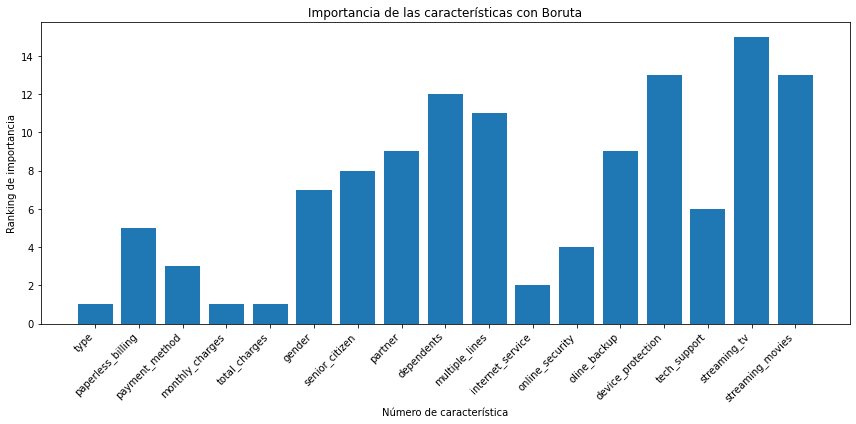

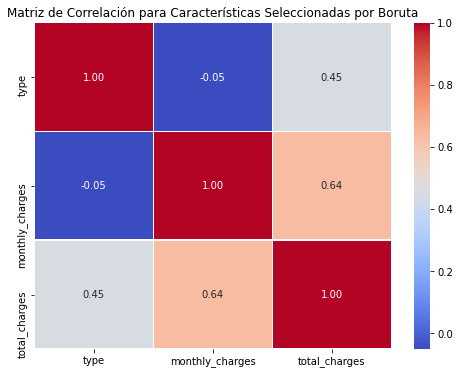

Características seleccionadas por Boruta:
Index(['type', 'monthly_charges', 'total_charges'], dtype='object')


In [48]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

boruta_selector = BorutaPy(rf, n_estimators='auto', random_state=42)
boruta_selector.fit(features_ordinal.values, target_ordinal.values)

selected_features = features_ordinal.columns[boruta_selector.support_]
selected_data = features_ordinal[selected_features]

correlation_matrix = selected_data.corr()

feature_ranks = boruta_selector.ranking_
num_features = features_ordinal.shape[1]

plt.figure(figsize=(12, 6))
plt.bar(range(num_features), feature_ranks)
plt.xticks(range(num_features), features_ordinal.columns, rotation=45, ha="right")
plt.xlabel('Número de característica')
plt.ylabel('Ranking de importancia')
plt.title('Importancia de las características con Boruta')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlación para Características Seleccionadas por Boruta')
plt.show()

print("Características seleccionadas por Boruta:")
print(selected_features)

Podemos ver que el algoritmo solamente nos da dos columnas como las mas importantes lo que realizaremos a continuacion sera entrenar modelos primero con todas las columnas y despues dejaremos solo algunas columnas que obtuvieron buenas puntuaciones que se muestran en el histograma anterior.

## Entrenamiento de modelos con todas las columnas.

A continuacion construiremos los dataframes codificados que necesitaremos para los lgoritmos de Logistic Regression y Random Forest Classifier ademas construiremos otro con los datos en tipo categorias para los algoritmos CatBoost y LightGBM.

In [49]:
random_state=200

In [50]:
data_ohe = pd.get_dummies(model_dataset, drop_first=True)
features_ohe = data_ohe.drop(['target'], axis=1)
target_ohe = data_ohe['target']

X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = train_test_split(features_ohe, 
                                                                    target_ohe, 
                                                                    test_size =0.142, 
                                                                    random_state=random_state)

X_train_ohe, X_valid_ohe, y_train_ohe, y_valid_ohe = train_test_split(X_train_ohe, 
                                                                      y_train_ohe, 
                                                                      test_size = 0.166, 
                                                                      random_state=random_state)

In [51]:
X_train_ordinal, X_test_ordinal, y_train_ordinal, y_test_ordinal = train_test_split(features_ordinal, 
                                                                                    target_ordinal, 
                                                                                    test_size = 0.142, 
                                                                                    random_state=random_state)

X_train_ordinal, X_valid_ordinal, y_train_ordinal, y_valid_ordinal = train_test_split(X_train_ordinal, 
                                                                                      y_train_ordinal, 
                                                                                      test_size = 0.166, 
                                                                                      random_state=random_state)

In [52]:
model_dataset.columns

Index(['type', 'paperless_billing', 'payment_method', 'monthly_charges',
       'total_charges', 'target', 'gender', 'senior_citizen', 'partner',
       'dependents', 'multiple_lines', 'internet_service', 'online_security',
       'oline_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')

In [53]:
model_dataset_cat = model_dataset.copy()
categories = ['type', 'paperless_billing', 'payment_method', 'gender', 'partner',
              'dependents', 'multiple_lines', 'internet_service', 'online_security',
              'oline_backup', 'device_protection', 'tech_support', 'streaming_tv',
              'streaming_movies']
model_dataset_cat[categories] = model_dataset_cat[categories].astype('category')

In [54]:
model_dataset_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   type               7043 non-null   category
 1   paperless_billing  7043 non-null   category
 2   payment_method     7043 non-null   category
 3   monthly_charges    7043 non-null   float64 
 4   total_charges      7043 non-null   float64 
 5   target             7043 non-null   int8    
 6   gender             7043 non-null   category
 7   senior_citizen     7043 non-null   int64   
 8   partner            7043 non-null   category
 9   dependents         7043 non-null   category
 10  multiple_lines     7043 non-null   category
 11  internet_service   7043 non-null   category
 12  online_security    7043 non-null   category
 13  oline_backup       7043 non-null   category
 14  device_protection  7043 non-null   category
 15  tech_support       7043 non-null   category
 16  stream

In [55]:
features_cat = model_dataset_cat.drop(['target'], axis=1)
target_cat = model_dataset_cat['target']


X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(features_cat,
                                                                    target_cat,
                                                                    test_size=0.142,
                                                                    random_state=random_state)

X_train_cat, X_valid_cat, y_train_cat, y_valid_cat = train_test_split(X_train_cat,
                                                                      y_train_cat,
                                                                      test_size=0.166,
                                                                      random_state=random_state)

### Logistic Regression

[[646  75]
 [142 140]]

recall 0.49645390070921985

precision 0.6511627906976745

f1 0.5633802816901409

auc_roc 0.8246230117744269


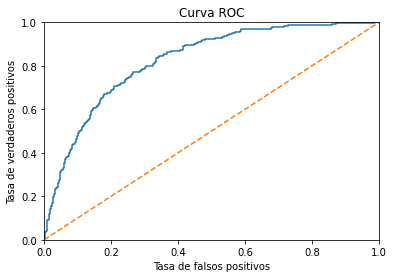

In [56]:
model = LogisticRegression(random_state=12345, solver = 'liblinear')
model.fit(X_train_ohe, y_train_ohe)
predicted_valid_ohe = model.predict(X_valid_ohe)

print(confusion_matrix(y_valid_ohe, predicted_valid_ohe))
print()
print('recall', recall_score(y_valid_ohe, predicted_valid_ohe))
print()
print('precision', precision_score(y_valid_ohe, predicted_valid_ohe))
print()
f1_lr = f1_score(y_valid_ohe, predicted_valid_ohe)
print('f1', f1_lr)
print()

probabilities_valid = model.predict_proba(X_valid_ohe)
probabilities_one_valid = probabilities_valid[:,1]

auc = roc_auc_score(y_valid_ohe, probabilities_one_valid)
print('auc_roc', auc)

fpr, tpr, thresholds = roc_curve(y_valid_ohe, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.show()

### Random Forest Classifier

In [57]:
best_score = 0
best_depth = 0

for est in range(1, 41, 10):
    for depth in range(1,21):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(X_train_ordinal, y_train_ordinal)
        score = model.score(X_valid_ordinal, y_valid_ordinal)

        if score > best_score:
            best_score = score
            best_est = est
            best_depth = depth

print('Accuracy del mejor modelo de validacion (score= {}, n_estimators= {}, depth= {}'.format(best_score, best_est, best_depth))

Accuracy del mejor modelo de validacion (score= 0.7856430707876371, n_estimators= 11, depth= 8


[[651  70]
 [145 137]]

recall 0.4858156028368794

precision 0.6618357487922706

f1 0.5603271983640082

auc_roc 0.8223187849814579


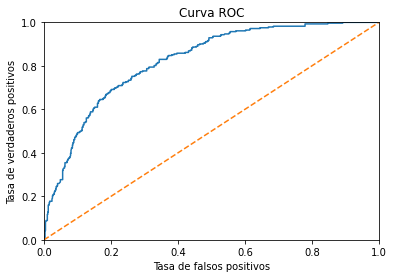

In [58]:
model = RandomForestClassifier(random_state=12345, n_estimators=11, max_depth=8)
model.fit(X_train_ordinal, y_train_ordinal)
predicted_valid_ordinal = model.predict(X_valid_ordinal)

print(confusion_matrix(y_valid_ordinal, predicted_valid_ordinal))
print()
print('recall', recall_score(y_valid_ordinal, predicted_valid_ordinal))
print()
print('precision', precision_score(y_valid_ordinal, predicted_valid_ordinal))
print()
f1_ordinal = f1_score(y_valid_ordinal, predicted_valid_ordinal)
print('f1', f1_ordinal)
print()

probabilities_valid = model.predict_proba(X_valid_ordinal)
probabilities_one_valid = probabilities_valid[:,1]

auc = roc_auc_score(y_valid_ordinal, probabilities_one_valid)
print('auc_roc', auc)

fpr, tpr, thresholds = roc_curve(y_valid_ordinal, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.show()

### Cat Boost

[[634  87]
 [140 142]]

recall 0.5035460992907801

precision 0.6200873362445415

f1 0.5557729941291586

auc_roc 0.8247926933632366


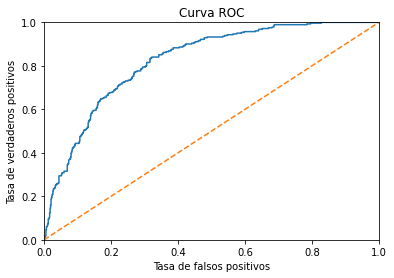

In [59]:
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    cat_features=['type', 'paperless_billing', 'payment_method', 'gender', 'partner',
              'dependents', 'multiple_lines', 'internet_service', 'online_security',
              'oline_backup', 'device_protection', 'tech_support', 'streaming_tv',
              'streaming_movies'],  
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    logging_level='Silent'
)

model.fit(X_train_cat, y_train_cat)
predicted_valid_cat = model.predict(X_valid_cat)

print(confusion_matrix(y_valid_cat, predicted_valid_cat))
print()
print('recall', recall_score(y_valid_cat, predicted_valid_cat))
print()
print('precision', precision_score(y_valid_cat, predicted_valid_cat))
print()
f1_cat = f1_score(y_valid_cat, predicted_valid_cat)
print('f1', f1_cat)
print()

probabilities_valid = model.predict_proba(X_valid_cat)
probabilities_one_valid = probabilities_valid[:,1]

auc = roc_auc_score(y_valid_cat, probabilities_one_valid)
print('auc_roc', auc)

fpr, tpr, thresholds = roc_curve(y_valid_cat, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.show()

### Light GBM

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's auc: 0.815551	valid_0's binary_logloss: 0.565597
[2]	valid_0's auc: 0.820147	valid_0's binary_logloss: 0.542855
[3]	valid_0's auc: 0.823794	valid_0's binary_logloss: 0.525089
[4]	valid_0's auc: 0.82466	valid_0's binary_logloss: 0.511089
[5]	valid_0's auc: 0.827033	valid_0's binary_logloss: 0.499073
[6]	valid_0's auc: 0.828317	valid_0's binary_logloss: 0.48979
[7]	valid_0's auc: 0.829064	valid_0's binary_logloss: 0.481438
[8]	valid_0's auc: 0.829745	valid_0's binary_logloss: 0.474633
[9]	valid_0's auc: 0.831123	valid_0's binary_logloss: 0.468625
[10]	valid_0's auc: 0.831477	valid_0's binary_logloss: 0.464045
[11]	valid_0's auc: 0.832	valid_0's binary_logloss: 0.459862
[12]	valid_0's auc: 0.831843	valid_0's binary_logloss: 0.457379
[13]	valid_0's auc: 0.832059	valid_0's binary_logloss: 0.454795
[14]	valid_0's auc: 0.831455	valid_0's binary_logloss: 0.453211
[15]	valid_0's auc: 0.83261	valid_0's binary_logloss: 0.451718
[16]	valid_0's auc: 0.832303	valid_0's binary_logloss: 

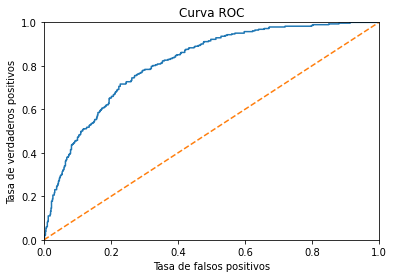

In [60]:
model = lgb.LGBMClassifier(random_state=42)
model.fit(X_train_cat, y_train_cat, eval_metric = 'AUC', eval_set=(X_valid_cat, y_valid_cat))
lgbm_pred = model.predict(X_valid_cat)

print(confusion_matrix(y_valid_cat, lgbm_pred))
print()
print('recall', recall_score(y_valid_cat, lgbm_pred))
print()
print('precision', precision_score(y_valid_cat, lgbm_pred))
print()
f1_cat = f1_score(y_valid_cat, lgbm_pred)
print('f1', f1_cat)
print()

probabilities_valid = model.predict_proba(X_valid_cat)
probabilities_one_valid = probabilities_valid[:,1]

auc = roc_auc_score(y_valid_cat, probabilities_one_valid)
print('auc_roc', auc)

fpr, tpr, thresholds = roc_curve(y_valid_cat, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.show()

En este caso en los cuatro modelos tenemos resultados muy parecidos en el 'AUC ROC' apenas por encima de 80 ahora pasaremosa entrenar modelos solamente con columnas que nos dio el algoritmo Boruta, de ser necesario usaremos mas columnas de las que nos proporciono mientras las metricas sigan aumentando.

## Entrenamiento de modelos con columnas de Boruta

In [61]:
model_dataset_2=model_dataset[['type', 'monthly_charges', 'total_charges', 'target', 'internet_service', 'payment_method',
                              'online_security', 'tech_support', 'paperless_billing']]
model_dataset_2.head()

,type,monthly_charges,total_charges,target,internet_service,payment_method,online_security,tech_support,paperless_billing
0,Month-to-month,29.85,29.85,0,DSL,Electronic check,No,No,Yes
1,One year,56.95,1889.50,0,DSL,Mailed check,Yes,No,No
2,Month-to-month,53.85,108.15,1,DSL,Mailed check,Yes,No,Yes
3,One year,42.30,1840.75,0,DSL,Bank transfer (automatic),Yes,Yes,No
4,Month-to-month,70.70,151.65,1,Fiber optic,Electronic check,No,No,Yes


In [62]:
data_ohe = pd.get_dummies(model_dataset_2, drop_first=True)
features_ohe = data_ohe.drop(['target'], axis=1)
target_ohe = data_ohe['target']

In [63]:
X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = train_test_split(features_ohe, 
                                                                    target_ohe, 
                                                                    test_size =0.142, 
                                                                    random_state=random_state)

X_train_ohe, X_valid_ohe, y_train_ohe, y_valid_ohe = train_test_split(X_train_ohe, 
                                                                      y_train_ohe, 
                                                                      test_size = 0.166, 
                                                                      random_state=random_state)

In [64]:
encoder = OrdinalEncoder()
data_ordinal = pd.DataFrame(encoder.fit_transform(model_dataset_2), columns=model_dataset_2.columns)
features_ordinal = data_ordinal.drop(['target'], axis=1)
target_ordinal = data_ordinal['target']

X_train_ordinal, X_test_ordinal, y_train_ordinal, y_test_ordinal = train_test_split(features_ordinal, 
                                                                                    target_ordinal, 
                                                                                    test_size = 0.142, 
                                                                                    random_state=random_state)

X_train_ordinal, X_valid_ordinal, y_train_ordinal, y_valid_ordinal = train_test_split(X_train_ordinal, 
                                                                                      y_train_ordinal, 
                                                                                      test_size = 0.166, 
                                                                                      random_state=random_state)

In [65]:
model_dataset_cat_2=model_dataset[['type', 'monthly_charges', 'total_charges', 'target', 'internet_service', 'payment_method',
                              'online_security', 'tech_support', 'paperless_billing']]

In [66]:
categories = ['type', 'internet_service', 'payment_method',
              'online_security', 'tech_support', 'paperless_billing']
model_dataset_cat_2[categories] = model_dataset_cat_2[categories].astype('category')

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [67]:
model_dataset_cat_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   type               7043 non-null   category
 1   monthly_charges    7043 non-null   float64 
 2   total_charges      7043 non-null   float64 
 3   target             7043 non-null   int8    
 4   internet_service   7043 non-null   category
 5   payment_method     7043 non-null   category
 6   online_security    7043 non-null   category
 7   tech_support       7043 non-null   category
 8   paperless_billing  7043 non-null   category
dtypes: category(6), float64(2), int8(1)
memory usage: 214.0 KB


In [68]:
features_cat = model_dataset_cat_2.drop(['target'], axis=1)
target_cat = model_dataset_cat_2['target']


X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(features_cat,
                                                                    target_cat,
                                                                    test_size=0.142,
                                                                    random_state=random_state)

X_train_cat, X_valid_cat, y_train_cat, y_valid_cat = train_test_split(X_train_cat,
                                                                      y_train_cat,
                                                                      test_size=0.166,
                                                                      random_state=random_state)

### Logistic Regression

[[640  81]
 [147 135]]

recall 0.4787234042553192

precision 0.625

f1 0.5421686746987951

auc_roc 0.8235631166327303


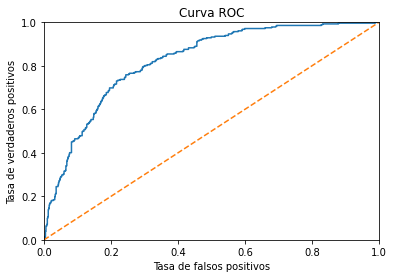

In [69]:
model = LogisticRegression(random_state=12345, solver = 'liblinear')
model.fit(X_train_ohe, y_train_ohe)
predicted_valid_ohe = model.predict(X_valid_ohe)

print(confusion_matrix(y_valid_ohe, predicted_valid_ohe))
print()
print('recall', recall_score(y_valid_ohe, predicted_valid_ohe))
print()
print('precision', precision_score(y_valid_ohe, predicted_valid_ohe))
print()
f1_lr = f1_score(y_valid_ohe, predicted_valid_ohe)
print('f1', f1_lr)
print()

probabilities_valid = model.predict_proba(X_valid_ohe)
probabilities_one_valid = probabilities_valid[:,1]

auc = roc_auc_score(y_valid_ohe, probabilities_one_valid)
print('auc_roc', auc)

fpr, tpr, thresholds = roc_curve(y_valid_ohe, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.show()

### Random Forest Classifier

In [70]:
best_score = 0
best_depth = 0

for est in range(1, 41, 10):
    for depth in range(1,21):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(X_train_ordinal, y_train_ordinal)
        score = model.score(X_valid_ordinal, y_valid_ordinal)

        if score > best_score:
            best_score = score
            best_est = est
            best_depth = depth

print('Accuracy del mejor modelo de validacion (score= {}, n_estimators= {}, depth= {}'.format(best_score, best_est, best_depth))

Accuracy del mejor modelo de validacion (score= 0.7906281156530409, n_estimators= 11, depth= 5


[[658  63]
 [147 135]]

recall 0.4787234042553192

precision 0.6818181818181818

f1 0.5625

auc_roc 0.8290667020784764


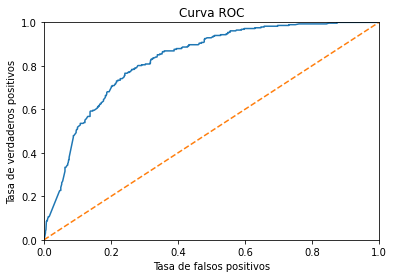

In [71]:
model = RandomForestClassifier(random_state=12345, n_estimators=11, max_depth=5)
model.fit(X_train_ordinal, y_train_ordinal)
predicted_valid_ordinal = model.predict(X_valid_ordinal)

print(confusion_matrix(y_valid_ordinal, predicted_valid_ordinal))
print()
print('recall', recall_score(y_valid_ordinal, predicted_valid_ordinal))
print()
print('precision', precision_score(y_valid_ordinal, predicted_valid_ordinal))
print()
f1_ordinal = f1_score(y_valid_ordinal, predicted_valid_ordinal)
print('f1', f1_ordinal)
print()

probabilities_valid = model.predict_proba(X_valid_ordinal)
probabilities_one_valid = probabilities_valid[:,1]

auc = roc_auc_score(y_valid_ordinal, probabilities_one_valid)
print('auc_roc', auc)

fpr, tpr, thresholds = roc_curve(y_valid_ordinal, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.show()

### CatBoost

[[642  79]
 [142 140]]

recall 0.49645390070921985

precision 0.639269406392694

f1 0.5588822355289421

auc_roc 0.834240760960447


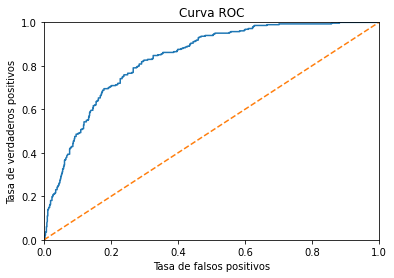

In [72]:
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    cat_features=['type', 'internet_service', 'payment_method',
              'online_security', 'tech_support', 'paperless_billing'],  
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    logging_level='Silent'
)

model.fit(X_train_cat, y_train_cat)
predicted_valid_cat = model.predict(X_valid_cat)

print(confusion_matrix(y_valid_cat, predicted_valid_cat))
print()
print('recall', recall_score(y_valid_cat, predicted_valid_cat))
print()
print('precision', precision_score(y_valid_cat, predicted_valid_cat))
print()
f1_cat = f1_score(y_valid_cat, predicted_valid_cat)
print('f1', f1_cat)
print()

probabilities_valid = model.predict_proba(X_valid_cat)
probabilities_one_valid = probabilities_valid[:,1]

auc = roc_auc_score(y_valid_cat, probabilities_one_valid)
print('auc_roc', auc)

fpr, tpr, thresholds = roc_curve(y_valid_cat, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.show()

In [73]:
#categorical_features = ['type', 'internet_service', 'payment_method',
#              'online_security', 'tech_support', 'paperless_billing']
#model = CatBoostClassifier(cat_features=categorical_features, random_state=42)
#
#param_grid = {
#    'depth': [4, 6, 8],
#    'learning_rate': [0.01, 0.05, 0.1],
#    'iterations': [50, 100, 150],
#    'l2_leaf_reg': [3, 5, 7],
#}
#
#grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=3)
#
#grid_search.fit(X_train_cat, y_train_cat, cat_features=categorical_features)
#
#best_params = grid_search.best_params_
#print(f"Mejores hiperparámetros: {best_params}")
#
#best_model = grid_search.best_estimator_
#
#y_pred_proba = best_model.predict_proba(X_valid_cat)[:, 1]
#
#auc_roc = roc_auc_score(y_valid_cat, y_pred_proba)
#print(f'AUC-ROC en conjunto de prueba: {auc_roc}')

In [74]:
#model = CatBoostClassifier(
#    iterations=150,
#    learning_rate=0.1,
#    depth=4,
#    l2_leaf_reg=3,
#    cat_features=['type', 'internet_service', 'payment_method',
#              'online_security', 'tech_support', 'paperless_billing'],  
#    loss_function='Logloss',
#    eval_metric='AUC',
#    random_seed=42,
#    logging_level='Silent'
#)
#
#model.fit(X_train_cat, y_train_cat)
#predicted_valid_cat = model.predict(X_valid_cat)
#
#print(confusion_matrix(y_valid_cat, predicted_valid_cat))
#print()
#print('recall', recall_score(y_valid_cat, predicted_valid_cat))
#print(#)
#print('precision', precision_score(y_valid_cat, predicted_valid_cat))
#print()
#f1_cat = f1_score(y_valid_cat, predicted_valid_cat)
#print('f1', f1_cat)
#print()
#
#probabilities_valid = model.predict_proba(X_valid_cat)
#probabilities_one_valid = probabilities_valid[:,1]
#
#auc = roc_auc_score(y_valid_cat, probabilities_one_valid)
#print('auc_roc', auc)
#
#fpr, tpr, thresholds = roc_curve(y_valid_cat, probabilities_one_valid)
#
#plt.figure()
#plt.plot(fpr, tpr)
#plt.plot([0,1], [0,1], linestyle='--')
#plt.xlim(0.0, 1.0)
#plt.ylim(0.0, 1.0)
#plt.xlabel('Tasa de falsos positivos')
#plt.ylabel('Tasa de verdaderos positivos')
#plt.title('Curva ROC')
#plt.show()

### Light GBM

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's auc: 0.813286	valid_0's binary_logloss: 0.566131
[2]	valid_0's auc: 0.820742	valid_0's binary_logloss: 0.543833
[3]	valid_0's auc: 0.822284	valid_0's binary_logloss: 0.525856
[4]	valid_0's auc: 0.82557	valid_0's binary_logloss: 0.511232
[5]	valid_0's auc: 0.826443	valid_0's binary_logloss: 0.499738
[6]	valid_0's auc: 0.82764	valid_0's binary_logloss: 0.490083
[7]	valid_0's auc: 0.827616	valid_0's binary_logloss: 0.482333
[8]	valid_0's auc: 0.828199	valid_0's binary_logloss: 0.476136
[9]	valid_0's auc: 0.829118	valid_0's binary_logloss: 0.470581
[10]	valid_0's auc: 0.830011	valid_0's binary_logloss: 0.465575
[11]	valid_0's auc: 0.829996	valid_0's binary_logloss: 0.462245
[12]	valid_0's auc: 0.831236	valid_0's binary_logloss: 0.458811
[13]	valid_0's auc: 0.831993	valid_0's binary_logloss: 0.456173
[14]	valid_0's auc: 0.832738	valid_0's binary_logloss: 0.453541
[15]	valid_0's auc: 0.833992	valid_0's binary_logloss: 0.451201
[16]	valid_0's auc: 0.834167	valid_0's binary_loglo

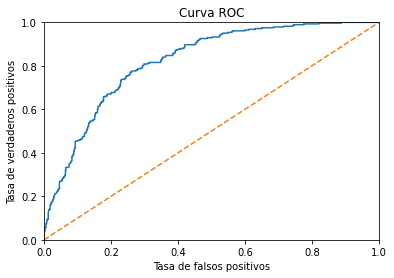

In [75]:
model = lgb.LGBMClassifier(random_state=42)
model.fit(X_train_cat, y_train_cat, eval_metric = 'AUC', eval_set=(X_valid_cat, y_valid_cat))
lgbm_pred = model.predict(X_valid_cat)

print(confusion_matrix(y_valid_cat, lgbm_pred))
print()
print('recall', recall_score(y_valid_cat, lgbm_pred))
print()
print('precision', precision_score(y_valid_cat, lgbm_pred))
print()
f1_cat = f1_score(y_valid_cat, lgbm_pred)
print('f1', f1_cat)
print()

probabilities_valid = model.predict_proba(X_valid_cat)
probabilities_one_valid = probabilities_valid[:,1]

auc = roc_auc_score(y_valid_cat, probabilities_one_valid)
print('auc_roc', auc)

fpr, tpr, thresholds = roc_curve(y_valid_cat, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.show()

In [76]:
model = lgb.LGBMClassifier(random_state=42)

param_grid = {
    'num_leaves': [30, 40],
    'max_depth': [5, 7],
    'learning_rate': [0.01, 0.05],
    'n_estimators': [50, 100],
    'min_child_samples': [20, 30],
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=3)

grid_search.fit(X_train_cat, y_train_cat)

best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

best_model = grid_search.best_estimator_

y_pred_proba = best_model.predict_proba(X_valid_cat)[:, 1]

auc_roc = roc_auc_score(y_valid_cat, y_pred_proba)
print(f'AUC-ROC en conjunto de prueba: {auc_roc}')

Mejores hiperparámetros: {'learning_rate': 0.05, 'max_depth': 5, 'min_child_samples': 30, 'n_estimators': 50, 'num_leaves': 40}
AUC-ROC en conjunto de prueba: 0.8337145021197903


[1]	valid_0's auc: 0.823647	valid_0's binary_logloss: 0.580377
[2]	valid_0's auc: 0.823563	valid_0's binary_logloss: 0.567529
[3]	valid_0's auc: 0.823664	valid_0's binary_logloss: 0.556045
[4]	valid_0's auc: 0.823949	valid_0's binary_logloss: 0.546025
[5]	valid_0's auc: 0.826605	valid_0's binary_logloss: 0.536526
[6]	valid_0's auc: 0.826241	valid_0's binary_logloss: 0.5284
[7]	valid_0's auc: 0.827195	valid_0's binary_logloss: 0.520924
[8]	valid_0's auc: 0.827289	valid_0's binary_logloss: 0.514146
[9]	valid_0's auc: 0.827758	valid_0's binary_logloss: 0.507898
[10]	valid_0's auc: 0.827567	valid_0's binary_logloss: 0.50236
[11]	valid_0's auc: 0.828435	valid_0's binary_logloss: 0.497133
[12]	valid_0's auc: 0.829086	valid_0's binary_logloss: 0.492319
[13]	valid_0's auc: 0.828917	valid_0's binary_logloss: 0.48818
[14]	valid_0's auc: 0.829305	valid_0's binary_logloss: 0.484265
[15]	valid_0's auc: 0.829873	valid_0's binary_logloss: 0.480832
[16]	valid_0's auc: 0.830038	valid_0's binary_logloss

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[30]	valid_0's auc: 0.833926	valid_0's binary_logloss: 0.45131
[31]	valid_0's auc: 0.833729	valid_0's binary_logloss: 0.450462
[32]	valid_0's auc: 0.833825	valid_0's binary_logloss: 0.449446
[33]	valid_0's auc: 0.834088	valid_0's binary_logloss: 0.448621
[34]	valid_0's auc: 0.834059	valid_0's binary_logloss: 0.447903
[35]	valid_0's auc: 0.834415	valid_0's binary_logloss: 0.447332
[36]	valid_0's auc: 0.834538	valid_0's binary_logloss: 0.446691
[37]	valid_0's auc: 0.834489	valid_0's binary_logloss: 0.44636
[38]	valid_0's auc: 0.834324	valid_0's binary_logloss: 0.44566
[39]	valid_0's auc: 0.834167	valid_0's binary_logloss: 0.445185
[40]	valid_0's auc: 0.834376	valid_0's binary_logloss: 0.444961
[41]	valid_0's auc: 0.834295	valid_0's binary_logloss: 0.444426
[42]	valid_0's auc: 0.83401	valid_0's binary_logloss: 0.44418
[43]	valid_0's auc: 0.834091	valid_0's binary_logloss: 0.443764
[44]	valid_0's auc: 0.833928	valid_0's binary_logloss: 0.443612
[45]	valid_0's auc: 0.834002	valid_0's binary

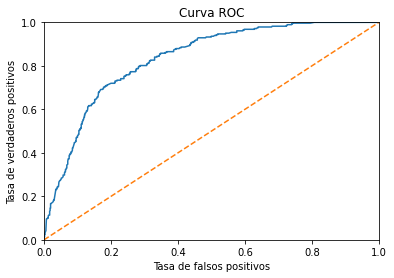

In [77]:
model = lgb.LGBMClassifier(learning_rate = 0.05, max_depth=5, min_child_samples=30, n_estimators=50, num_leaves=40, random_state=42)
model.fit(X_train_cat, y_train_cat, eval_metric = 'AUC', eval_set=(X_valid_cat, y_valid_cat))
lgbm_pred = model.predict(X_valid_cat)

print(confusion_matrix(y_valid_cat, lgbm_pred))
print()
print('recall', recall_score(y_valid_cat, lgbm_pred))
print()
print('precision', precision_score(y_valid_cat, lgbm_pred))
print()
f1_cat = f1_score(y_valid_cat, lgbm_pred)
print('f1', f1_cat)
print()

probabilities_valid = model.predict_proba(X_valid_cat)
probabilities_one_valid = probabilities_valid[:,1]

auc = roc_auc_score(y_valid_cat, probabilities_one_valid)
print('auc_roc', auc)

fpr, tpr, thresholds = roc_curve(y_valid_cat, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.show()

En este caso tenemos casi los mismos resultados que en un principio por lo que en este caso podemos concluir que el quitar algunas columnas mejora algunos modelos pero no son realmente relevantes ademas en esta busqueda el modelo CatBoost tarda mucho pero se menciona el caso del modelo 'Light GBM' que si aumenta alrededor de 3 puntos, en la siguiente atapa no buscaremos hiperparametros para CatBoost pero si para LightGBM que son mas rapidos de establecer, ahora pasaremos al sobreajuste. 

## Sobreajuste

In [78]:
count_class_0, count_class_1 = model_dataset.target.value_counts()
data_class_0 = model_dataset[model_dataset['target'] == 0]
data_class_1 = model_dataset[model_dataset['target'] == 1]
print(data_class_0.shape)
print(data_class_1.shape)

(5174, 18)
(1869, 18)


In [79]:
data_class_1_over = data_class_1.sample(count_class_0, replace =True)

model_dataset_over = pd.concat([data_class_0, data_class_1_over], axis=0)

model_dataset_over.target.value_counts()

0    5174
1    5174
Name: target, dtype: int64

In [80]:
model_dataset_over

,type,paperless_billing,payment_method,monthly_charges,total_charges,target,gender,senior_citizen,partner,dependents,multiple_lines,internet_service,online_security,oline_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,Month-to-month,Yes,Electronic check,29.85,29.85,0,Female,0,Yes,No,No,DSL,No,Yes,No,No,No,No
1,One year,No,Mailed check,56.95,1889.50,0,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No
3,One year,No,Bank transfer (automatic),42.30,1840.75,0,Male,0,No,No,No,DSL,Yes,No,Yes,Yes,No,No
6,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,0,Male,0,No,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No
7,Month-to-month,No,Mailed check,29.75,301.90,0,Female,0,No,No,No,DSL,Yes,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1306,One year,No,Credit card (automatic),115.55,8127.60,1,Female,0,No,No,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes
1919,Month-to-month,No,Mailed check,50.90,50.90,1,Male,0,No,No,No,DSL,No,No,Yes,No,No,No
3831,One year,Yes,Electronic check,89.05,2177.45,1,Male,1,Yes,No,Yes,Fiber optic,Yes,No,No,No,No,Yes
648,Month-to-month,No,Electronic check,89.50,161.50,1,Female,1,No,No,Yes,Fiber optic,No,Yes,No,No,No,Yes


In [81]:
data_ohe = pd.get_dummies(model_dataset_over, drop_first=True)
features_ohe = data_ohe.drop(['target'], axis=1)
target_ohe = data_ohe['target']

X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = train_test_split(features_ohe, 
                                                                    target_ohe, 
                                                                    test_size =0.20, 
                                                                    random_state=random_state)

X_train_ohe, X_valid_ohe, y_train_ohe, y_valid_ohe = train_test_split(X_train_ohe, 
                                                                      y_train_ohe, 
                                                                      test_size = 0.25, 
                                                                      random_state=random_state)

In [82]:
X_test_ohe.shape

(2070, 21)

In [83]:
encoder = OrdinalEncoder()
data_ordinal = pd.DataFrame(encoder.fit_transform(model_dataset_over), columns=model_dataset_over.columns)
features_ordinal = data_ordinal.drop(['target'], axis=1)
target_ordinal = data_ordinal['target']

X_train_ordinal, X_test_ordinal, y_train_ordinal, y_test_ordinal = train_test_split(features_ordinal, 
                                                                                    target_ordinal, 
                                                                                    test_size = 0.20, 
                                                                                    random_state=random_state)

X_train_ordinal, X_valid_ordinal, y_train_ordinal, y_valid_ordinal = train_test_split(X_train_ordinal, 
                                                                                      y_train_ordinal, 
                                                                                      test_size = 0.25, 
                                                                                      random_state=random_state)

In [84]:
X_valid_ordinal.shape

(2070, 17)

In [85]:
model_dataset_cat = model_dataset_over.copy()
categories = ['type', 'paperless_billing', 'payment_method', 'gender', 'partner',
              'dependents', 'multiple_lines', 'internet_service', 'online_security',
              'oline_backup', 'device_protection', 'tech_support', 'streaming_tv',
              'streaming_movies']
model_dataset_cat[categories] = model_dataset_cat[categories].astype('category')

In [86]:
features_cat = model_dataset_cat.drop(['target'], axis=1)
target_cat = model_dataset_cat['target']


X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(features_cat,
                                                                    target_cat,
                                                                    test_size=0.20,
                                                                    random_state=random_state)

X_train_cat, X_valid_cat, y_train_cat, y_valid_cat = train_test_split(X_train_cat,
                                                                      y_train_cat,
                                                                      test_size=0.25,
                                                                      random_state=random_state)

In [87]:
X_test_cat.shape

(2070, 17)

### Logistic Regression

[[745 249]
 [208 868]]

recall 0.8066914498141264

precision 0.7770814682184423

f1 0.7916096671226629

auc_roc 0.8446010636308557


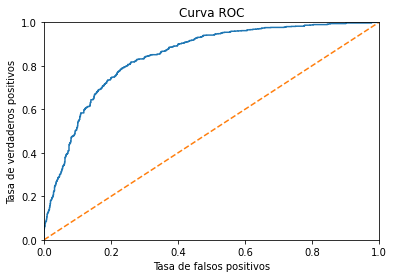

In [88]:
model = LogisticRegression(random_state=12345, solver = 'liblinear')
model.fit(X_train_ohe, y_train_ohe)
predicted_valid_ohe = model.predict(X_valid_ohe)

print(confusion_matrix(y_valid_ohe, predicted_valid_ohe))
print()
print('recall', recall_score(y_valid_ohe, predicted_valid_ohe))
print()
print('precision', precision_score(y_valid_ohe, predicted_valid_ohe))
print()
f1_lr = f1_score(y_valid_ohe, predicted_valid_ohe)
print('f1', f1_lr)
print()

probabilities_valid = model.predict_proba(X_valid_ohe)
probabilities_one_valid = probabilities_valid[:,1]

auc = roc_auc_score(y_valid_ohe, probabilities_one_valid)
print('auc_roc', auc)

fpr, tpr, thresholds = roc_curve(y_valid_ohe, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.show()

### Random Forest Classifier

In [89]:
best_score = 0
best_depth = 0

for est in range(1, 41, 10):
    for depth in range(1,21):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(X_train_ordinal, y_train_ordinal)
        score = model.score(X_valid_ordinal, y_valid_ordinal)

        if score > best_score:
            best_score = score
            best_est = est
            best_depth = depth

print('Accuracy del mejor modelo de validacion (score= {}, n_estimators= {}, depth= {}'.format(best_score, best_est, best_depth))

Accuracy del mejor modelo de validacion (score= 0.8874396135265701, n_estimators= 21, depth= 20


[[801 193]
 [ 85 991]]

recall 0.921003717472119

precision 0.8369932432432432

f1 0.8769911504424778

auc_roc 0.9431865355702991


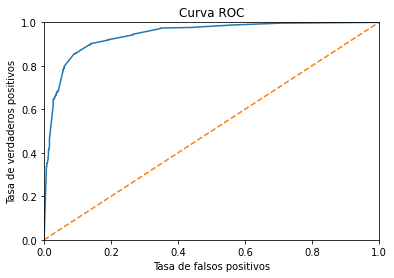

In [90]:
model = RandomForestClassifier(random_state=12345, n_estimators=11, max_depth=19)
model.fit(X_train_ordinal, y_train_ordinal)
predicted_valid_ordinal = model.predict(X_valid_ordinal)

print(confusion_matrix(y_valid_ordinal, predicted_valid_ordinal))
print()
print('recall', recall_score(y_valid_ordinal, predicted_valid_ordinal))
print()
print('precision', precision_score(y_valid_ordinal, predicted_valid_ordinal))
print()
f1_ordinal = f1_score(y_valid_ordinal, predicted_valid_ordinal)
print('f1', f1_ordinal)
print()

probabilities_valid = model.predict_proba(X_valid_ordinal)
probabilities_one_valid = probabilities_valid[:,1]

auc = roc_auc_score(y_valid_ordinal, probabilities_one_valid)
print('auc_roc', auc)

fpr, tpr, thresholds = roc_curve(y_valid_ordinal, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.show()

### Cat Boost

[[772 222]
 [125 951]]

recall 0.8838289962825279

precision 0.8107416879795396

f1 0.8457092040907068

auc_roc 0.9022195440299792


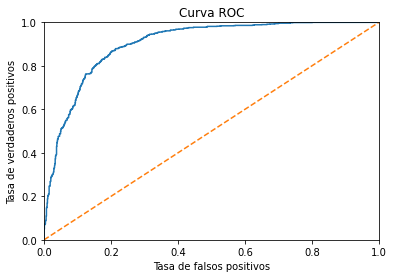

In [91]:
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    cat_features=['type', 'paperless_billing', 'payment_method', 'gender', 'partner',
              'dependents', 'multiple_lines', 'internet_service', 'online_security',
              'oline_backup', 'device_protection', 'tech_support', 'streaming_tv',
              'streaming_movies'],  
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    logging_level='Silent'
)

model.fit(X_train_cat, y_train_cat)
predicted_valid_cat = model.predict(X_valid_cat)

print(confusion_matrix(y_valid_cat, predicted_valid_cat))
print()
print('recall', recall_score(y_valid_cat, predicted_valid_cat))
print()
print('precision', precision_score(y_valid_cat, predicted_valid_cat))
print()
f1_cat = f1_score(y_valid_cat, predicted_valid_cat)
print('f1', f1_cat)
print()

probabilities_valid = model.predict_proba(X_valid_cat)
probabilities_one_valid = probabilities_valid[:,1]

auc = roc_auc_score(y_valid_cat, probabilities_one_valid)
print('auc_roc', auc)

fpr, tpr, thresholds = roc_curve(y_valid_cat, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.show()

### Light GBM

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's auc: 0.852206	valid_0's binary_logloss: 0.656682
[2]	valid_0's auc: 0.853409	valid_0's binary_logloss: 0.626967
[3]	valid_0's auc: 0.853008	valid_0's binary_logloss: 0.60267
[4]	valid_0's auc: 0.853765	valid_0's binary_logloss: 0.582314
[5]	valid_0's auc: 0.853826	valid_0's binary_logloss: 0.565349
[6]	valid_0's auc: 0.856067	valid_0's binary_logloss: 0.550773
[7]	valid_0's auc: 0.855769	valid_0's binary_logloss: 0.5385
[8]	valid_0's auc: 0.857156	valid_0's binary_logloss: 0.527801
[9]	valid_0's auc: 0.858623	valid_0's binary_logloss: 0.518465
[10]	valid_0's auc: 0.858906	valid_0's binary_logloss: 0.510665
[11]	valid_0's auc: 0.858703	valid_0's binary_logloss: 0.503913
[12]	valid_0's auc: 0.860447	valid_0's binary_logloss: 0.497228
[13]	valid_0's auc: 0.860327	valid_0's binary_logloss: 0.492208
[14]	valid_0's auc: 0.861368	valid_0's binary_logloss: 0.487078
[15]	valid_0's auc: 0.861868	valid_0's binary_logloss: 0.482746
[16]	valid_0's auc: 0.862557	valid_0's binary_loglos

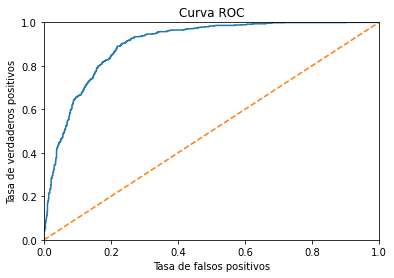

In [92]:
model = lgb.LGBMClassifier(random_state=42)
model.fit(X_train_cat, y_train_cat, eval_metric = 'AUC', eval_set=(X_valid_cat, y_valid_cat))
lgbm_pred = model.predict(X_valid_cat)

print(confusion_matrix(y_valid_cat, lgbm_pred))
print()
print('recall', recall_score(y_valid_cat, lgbm_pred))
print()
print('precision', precision_score(y_valid_cat, lgbm_pred))
print()
f1_cat = f1_score(y_valid_cat, lgbm_pred)
print('f1', f1_cat)
print()

probabilities_valid = model.predict_proba(X_valid_cat)
probabilities_one_valid = probabilities_valid[:,1]

auc = roc_auc_score(y_valid_cat, probabilities_one_valid)
print('auc_roc', auc)

fpr, tpr, thresholds = roc_curve(y_valid_cat, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.show()

In [93]:
model = lgb.LGBMClassifier(random_state=42)

param_grid = {
    'num_leaves': [30, 40],
    'max_depth': [5, 7],
    'learning_rate': [0.01, 0.05],
    'n_estimators': [50, 100],
    'min_child_samples': [20, 30],
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=3)

grid_search.fit(X_train_cat, y_train_cat)

best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

best_model = grid_search.best_estimator_

y_pred_proba = best_model.predict_proba(X_valid_cat)[:, 1]

auc_roc = roc_auc_score(y_valid_cat, y_pred_proba)
print(f'AUC-ROC en conjunto de prueba: {auc_roc}')

Mejores hiperparámetros: {'learning_rate': 0.05, 'max_depth': 7, 'min_child_samples': 20, 'n_estimators': 100, 'num_leaves': 40}
AUC-ROC en conjunto de prueba: 0.8870682272071089


[1]	valid_0's auc: 0.796015	valid_0's binary_logloss: 0.679167


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[2]	valid_0's auc: 0.807108	valid_0's binary_logloss: 0.666423
[3]	valid_0's auc: 0.807108	valid_0's binary_logloss: 0.65479
[4]	valid_0's auc: 0.808243	valid_0's binary_logloss: 0.644174
[5]	valid_0's auc: 0.817214	valid_0's binary_logloss: 0.634626
[6]	valid_0's auc: 0.818901	valid_0's binary_logloss: 0.625725
[7]	valid_0's auc: 0.818901	valid_0's binary_logloss: 0.617738
[8]	valid_0's auc: 0.818901	valid_0's binary_logloss: 0.610251
[9]	valid_0's auc: 0.827097	valid_0's binary_logloss: 0.603384
[10]	valid_0's auc: 0.827097	valid_0's binary_logloss: 0.597059
[11]	valid_0's auc: 0.827102	valid_0's binary_logloss: 0.591309
[12]	valid_0's auc: 0.827102	valid_0's binary_logloss: 0.585856
[13]	valid_0's auc: 0.82928	valid_0's binary_logloss: 0.580545
[14]	valid_0's auc: 0.830164	valid_0's binary_logloss: 0.575959
[15]	valid_0's auc: 0.830164	valid_0's binary_logloss: 0.571692
[16]	valid_0's auc: 0.829838	valid_0's binary_logloss: 0.567637
[17]	valid_0's auc: 0.831263	valid_0's binary_logl

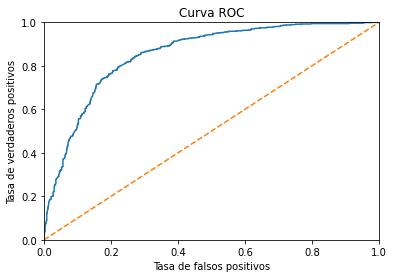

In [94]:
model = lgb.LGBMClassifier(learning_rate = 0.05, max_depth=7, min_child_samples=20, n_estimators=100, num_leaves=4, random_state=42)
model.fit(X_train_cat, y_train_cat, eval_metric = 'AUC', eval_set=(X_valid_cat, y_valid_cat))
lgbm_pred = model.predict(X_valid_cat)

print(confusion_matrix(y_valid_cat, lgbm_pred))
print()
print('recall', recall_score(y_valid_cat, lgbm_pred))
print()
print('precision', precision_score(y_valid_cat, lgbm_pred))
print()
f1_cat = f1_score(y_valid_cat, lgbm_pred)
print('f1', f1_cat)
print()

probabilities_valid = model.predict_proba(X_valid_cat)
probabilities_one_valid = probabilities_valid[:,1]

auc = roc_auc_score(y_valid_cat, probabilities_one_valid)
print('auc_roc', auc)

fpr, tpr, thresholds = roc_curve(y_valid_cat, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.show()

En estos modelos entrenados con sobreajuste tenemos los mejores resultados llegando todos caso a 90 y superandolo con el modelo Random Forest Classifier por lo que nos quedaremos con este modelo y haremos una prueba final con los datos de prueba.

## Prueba final 

Para esta prueba tomaremos el dataframe sobreajustado y todas las columnas ya que asi obtuvimos los mejores resultados y con los mejores hiperparametros.

In [95]:
model = RandomForestClassifier(random_state=12345, n_estimators=11, max_depth=19)
model.fit(X_train_ordinal, y_train_ordinal)
predictions = model.predict(X_test_ordinal)

[[860 208]
 [ 66 936]]

recall 0.9341317365269461

precision 0.8181818181818182

f1 0.8723205964585276

auc_roc 0.9445948926117801


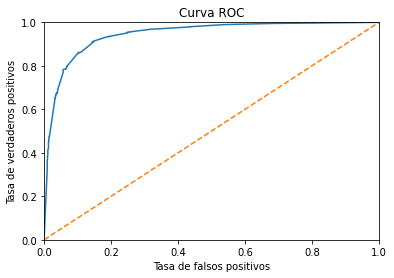

In [96]:
print(confusion_matrix(y_test_ordinal, predictions))
print()
print('recall', recall_score(y_test_ordinal, predictions))
print()
print('precision', precision_score(y_test_ordinal, predictions))
print()
f1_ordinal = f1_score(y_test_ordinal, predictions)
print('f1', f1_ordinal)
print()

probabilities_valid = model.predict_proba(X_test_ordinal)
probabilities_one_valid = probabilities_valid[:,1]

auc = roc_auc_score(y_test_ordinal, probabilities_one_valid)
print('auc_roc', auc)

fpr, tpr, thresholds = roc_curve(y_test_ordinal, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.show()

Tenemos resultados muy parecidos solo podemos decir que este es el mejor modelo para esta tarea, sin embargo posiblemente los algoritmos de potenciacion de gradiente nos darian mejores resultados pero requerirrian mucho mas tiempo para ser entrenados y en la busqueda de los hiperparametros que mejoren sus predicciones o posiblemente haciendo un sobreajuste mayor, por ultimo haremos una prueba usando las columnas que nos dio Boruta y el modelo Random Forest Classifier.

## Prueba sobreajuste con columnas boruta

En este caso haremos nuevamente una prueba del dataset sobreajustado usando las columnas que mejores resultados nos dieron despues de usar el algoritmo Boruta, pero solo lo usaremos con el algoritmo Random Forest Classifier que es el que mejores resultados nos ha dado.

In [97]:
model_dataset_3=model_dataset_over[['type', 'monthly_charges', 'total_charges', 'target', 'internet_service', 'payment_method',
                              'online_security', 'tech_support', 'paperless_billing']]
model_dataset_3

,type,monthly_charges,total_charges,target,internet_service,payment_method,online_security,tech_support,paperless_billing
0,Month-to-month,29.85,29.85,0,DSL,Electronic check,No,No,Yes
1,One year,56.95,1889.50,0,DSL,Mailed check,Yes,No,No
3,One year,42.30,1840.75,0,DSL,Bank transfer (automatic),Yes,Yes,No
6,Month-to-month,89.10,1949.40,0,Fiber optic,Credit card (automatic),No,No,Yes
7,Month-to-month,29.75,301.90,0,DSL,Mailed check,Yes,No,No
...,...,...,...,...,...,...,...,...,...
1306,One year,115.55,8127.60,1,Fiber optic,Credit card (automatic),Yes,Yes,No
1919,Month-to-month,50.90,50.90,1,DSL,Mailed check,No,No,No
3831,One year,89.05,2177.45,1,Fiber optic,Electronic check,Yes,No,Yes
648,Month-to-month,89.50,161.50,1,Fiber optic,Electronic check,No,No,No


In [98]:
encoder = OrdinalEncoder()
data_ordinal = pd.DataFrame(encoder.fit_transform(model_dataset_3), columns=model_dataset_3.columns)
features_ordinal = data_ordinal.drop(['target'], axis=1)
target_ordinal = data_ordinal['target']

X_train_ordinal, X_test_ordinal, y_train_ordinal, y_test_ordinal = train_test_split(features_ordinal, 
                                                                                    target_ordinal, 
                                                                                    test_size = 0.20, 
                                                                                    random_state=random_state)

X_train_ordinal, X_valid_ordinal, y_train_ordinal, y_valid_ordinal = train_test_split(X_train_ordinal, 
                                                                                      y_train_ordinal, 
                                                                                      test_size = 0.25, 
                                                                                      random_state=random_state)

In [99]:
best_score = 0
best_depth = 0

for est in range(1, 41, 10):
    for depth in range(1,21):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(X_train_ordinal, y_train_ordinal)
        score = model.score(X_valid_ordinal, y_valid_ordinal)

        if score > best_score:
            best_score = score
            best_est = est
            best_depth = depth

print('Accuracy del mejor modelo de validacion (score= {}, n_estimators= {}, depth= {}'.format(best_score, best_est, best_depth))

Accuracy del mejor modelo de validacion (score= 0.8705314009661835, n_estimators= 31, depth= 17


[[ 785  209]
 [  67 1009]]

recall 0.9377323420074349

precision 0.8284072249589491

f1 0.8796861377506539

auc_roc 0.9320701158624609


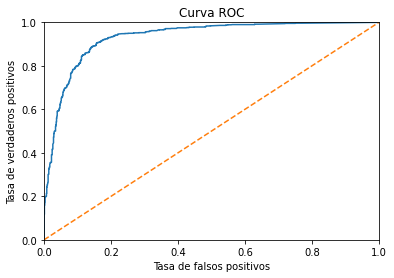

In [100]:
model = RandomForestClassifier(random_state=12345, n_estimators=21, max_depth=14)
model.fit(X_train_ordinal, y_train_ordinal)
predicted_valid_ordinal = model.predict(X_valid_ordinal)

print(confusion_matrix(y_valid_ordinal, predicted_valid_ordinal))
print()
print('recall', recall_score(y_valid_ordinal, predicted_valid_ordinal))
print()
print('precision', precision_score(y_valid_ordinal, predicted_valid_ordinal))
print()
f1_ordinal = f1_score(y_valid_ordinal, predicted_valid_ordinal)
print('f1', f1_ordinal)
print()

probabilities_valid = model.predict_proba(X_valid_ordinal)
probabilities_one_valid = probabilities_valid[:,1]

auc = roc_auc_score(y_valid_ordinal, probabilities_one_valid)
print('auc_roc', auc)

fpr, tpr, thresholds = roc_curve(y_valid_ordinal, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.show()

Vemos que despues de esta prueba no podemos superar los resultados que obtuvimos con todas las columnas y dataframe sobreajustado.

### Conclusion.

En este trabajo los algoritmos que nos habian dado los mejores resultados en anteriores proyectos no pudimos replicarlos y el modelo Random Forest Classifier nos dio los mejores resultados superando los 90 puntos en AUC ROC.

Usamos el sobreajuste para contrarrestar el desbalance y nos dio mejores resultados que las columnas dadas por el algoritmo Boruta y posiblemente mejor que si solamente usaramos el hiperparametro de balance ya que en anteriores proyectos se uso y no dio los mismos resultados que un sobreajuste.

Usamos varias metricas para evaluar los modelos y establecer en mejor medida sus alcances y donde podemos mejorarlos.

## Informe de Solucion

1.- ¿Qué pasos del plan se realizaron y qué pasos se omitieron (explica por qué)?

Los pasos que se habian descrito en el plande trabajo se llevarona  cabo todos, sin embargo se implementaron cambios que daban mejores resultados durante el desarrollo y algunos otros que se habian omitido en el mismo plan como es el caso del desbalance que no se habia mecionado y lo solucionamos son sobreajuste que no habia dado resultados en proyecto anteriores y fue lo que nos dio los modelos con mejores resultados.

Otro cambio fue tambien que al momento de contruir el algoritmo 'Boruta' se hizo con Ordinal Encoder y ya no con Label encoder ya que en las pruebas que realizamos los modelos no daban buenos resultados con esa codificacion y los resultados que nos daba el algoritmo 'Boruta' fueron los mismos con los dos metodos de codificacion por lo que se decidio omitir el 'Label Encoder' y sustituirlo por los metodos 'One Hot Encoder' y 'Ordinal Encoder'.

Y en el caso de las metricas para evaluar el modelo utilizamos varias de ellas sin embargo nos centramos en la que se nos decia se calificaria en el desarrollo del proyecto.


2.- ¿Qué dificultades encontraste y cómo lograste resolverlas?

Las dificultades fueron principalmente el tiempo que llevaba el algoritmo 'CatBoost' en entrenarse con una busqueda extensa de hiperparaetros lo que nos hubiera dado posiblemente mejores resultados y nos dimos cuenta que si bajabamos los rangos para la busqueda de hiperparametros los modelos casi no mejoraban y de hecho en uno de ellos aunque mejoro no alcanzo a nuestro mejor modelo que fue 'Randon Forest Classification' por lo que se opto por quedarnos con este modelo ya que su puntaje de 'AUC ROC' fue aceptable.

3.- ¿Cuáles fueron algunos de los pasos clave para resolver la tarea?

Pensabamos en un principio que el seleccionar algunas columnas aumentaria el nivel de calidad del modelo, sin embargo no fue asi y lo que realmente funciono fue realizar Sobreajuste, esto ya se habia probado en otro proyecto y dio muy buenos resultados por eso se implemento como metodo para contrarestar el desbalance y como podemos ver fue una buena desicion sin demeritar lo que logramos con el algoritmo 'Boruta' que aunque en esta ocacion no dio mejores reaultados en otros proyectos puede ser de utilidad.

4.- ¿Cuál es tu modelo final y qué nivel de calidad tiene?

El modelo que elegimos al final fue 'Random Forest Classifier' y solamente mencionaremos dos metricas que son las que considermos mas importantes que son 'f1' y 'ROC AUC' sus puntajes son los siguientes:con un puntaje en validacion 'f1 de 0.8723 y auc_roc 0.9445' y en prueba sus resultados fueron 'f1 0.8796 y auc_roc 0.9320.